##Question # 1

In [1]:
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)


In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions


<IPython.core.display.Javascript object>

In [3]:
def calc_entropy(column):
    counts = np.bincount(column)
    probabilities = counts / len(column)
    entropy = 0
    # Loop through the probabilities
    for prob in probabilities:
        if prob > 0:
            entropy += prob * math.log(prob, 2)
    
    return -entropy

<IPython.core.display.Javascript object>

In [4]:
def candidate_split(df,col_name):
  data=df.sort_values(col_name)
  data["change"]=data["y"].shift() != data["y"]
  #print(data)
  thresholds=[]
  for _,row in data[1:].iterrows():
    if(row['change']==True):
      #print(row)
      thresholds.append(row[col_name])
  #print(thresholds)
  return np.unique(np.array(thresholds))


<IPython.core.display.Javascript object>

In [51]:
def make_subtree(df):
  ##step 1 --> to calculate entropy of target
  H_y= calc_entropy(df['y'])
  #print(H_y)
  infogain=0
  infogain_ratio=0
  node='x1'
  split_val=0
  entropy=0
  for i in range(0,2):
    col_name=df.columns[i]
    #print(col_name)
    thresholds=candidate_split(df, col_name)
    #print(thresholds)
    for each in thresholds:
      data1=df[df[col_name]>=each]
      ent1=calc_entropy(data1['y'])
      data2=df[df[col_name]<each]
      ent2=calc_entropy(data2['y'])
      ent=(data1.shape[0]/df.shape[0])*(ent1)+(data2.shape[0]/df.shape[0])*(ent2)
      S=[1 if x >=each else 0 for x in df[col_name]]
      ent_S=calc_entropy(S)
      IG = (H_y-ent)
      IGratio=((H_y-ent)/ent_S)
      if(infogain_ratio<=((H_y-ent)/ent_S)):
        infogain = (H_y-ent)
        infogain_ratio=((H_y-ent)/ent_S)
        node=col_name
        split_val=each
        entropy = ent
      print("feature Node: ",col_name, "Split value: ",each, "Entropy:", ent, "Infogain: ", IG, "Infogain_ratio: ",IGratio)
  print( "Best feature Node: ",node, "Best Split value: ",split_val, "Entropy:", entropy, "Infogain: ", infogain, "Infogain_ratio: ",infogain_ratio)
  return node,split_val,infogain_ratio

<IPython.core.display.Javascript object>

In [52]:
def leaf_value(data):
  Y=list(data)
  pred = max(Y, key=Y.count)
  return pred

<IPython.core.display.Javascript object>

In [53]:

class Node():
  def __init__(self, feature_index=None, threshold=None, left=None, right=None, infogain_ratio=None, value=None):
    self.feature_index = feature_index
    self.threshold = threshold
    self.left = left
    self.right = right
    self.infogain_ratio = infogain_ratio

    self.value = value

<IPython.core.display.Javascript object>

In [54]:
depth=0
space='   '
def make_DT(df,depth):
  #and len(df['y'].unique())>1
  if(df.shape[0]>1):
    node, split_val,infogain_ratio=make_subtree(df)
    
    #if(depth==0):
      #print("Total Number of samples: ",df.shape[0])
    #print(space*depth, "Node: ",node," >= ",split_val," infogain_ratio: ",infogain_ratio)
    if(infogain_ratio>0):
      depth+=1
      left_tree=df[df[node]>=split_val]
      right_tree=df[df[node]<split_val] 
      #print(space*depth,"Left Child: ")
      left_subtree=make_DT(left_tree,depth)
      #print(space*depth,"Right Child: ")
      right_subtree=make_DT(right_tree,depth)
      return Node(node, split_val, left_subtree, right_subtree, infogain_ratio)

  pred = leaf_value(df['y'])
  return Node(value=pred)

      
  
  

<IPython.core.display.Javascript object>

In [55]:
#without predictions
#dry run
#make_DT(df,depth)

<IPython.core.display.Javascript object>

##Question # 2

In [56]:

class classifier():
  node_count=0
  def __init__(self):
    self.root=None
  def fit(self, dataset):
    self.root = make_DT(dataset, depth)
  def predict(self,X):
    predictions = np.array([self.make_prediction(x, self.root) for x in X])

    return predictions
  def make_prediction(self, x, tree):
    if tree.value != None:
      return tree.value

    feature_val = x[int(tree.feature_index[1:])-1]
    if feature_val >= tree.threshold:
      return self.make_prediction(x, tree.left)
    else:
      return self.make_prediction(x, tree.right)
  
  def print_tree(self, tree=None, indent="     "):
    space ="     "
    if not tree: 
      tree=self.root
    if tree.value is not None:
      print(tree.value)
      self.node_count+=1
    else:
      print("Node: "+str(tree.feature_index), ">=", tree.threshold, "( Infogain_ratio: ", tree.infogain_ratio,")")
      self.node_count+=1
      print("%sleft child:" % (indent),end="")
      self.print_tree(tree.left, indent +space)
      print("%sright child:" % (indent),end="")
      self.print_tree(tree.right, indent+space)
    return self.node_count

<IPython.core.display.Javascript object>

In [57]:
def boundry_plots(df,name,classifier):
  fig, ax = plt.subplots(figsize=(5, 5)) 
  X=df.iloc[:,:-1]
  X=X.to_numpy()
  plot_decision_regions(X, df['y'].to_numpy(), clf=classifier) 
  plt.xlabel('x_1') 
  plt.ylabel('x_2') 
  plt.title("Decision Boundry for "+name)
  plt.legend(loc='upper left') 
  plt.tight_layout() 
  plt.show()

<IPython.core.display.Javascript object>

In [58]:
from sklearn.metrics import accuracy_score, mean_squared_error
def print_acc_err(df, test):
  cf=classifier()
  cf.fit(df)
  X=test.iloc[:,:-1]
  X=X.to_numpy()
  print("D",df.shape[0])
  #print(X.shape)
  Ypred=cf.predict(X)
  #print(Ypred)
  boundry_plots(df,("D"+str(df.shape[0])),cf)
  nodes=cf.print_tree()
  Acc=accuracy_score(Ypred,test['y'])
  Err=mean_squared_error(Ypred, test['y'])
  print("Accuracy: ",Acc, "Mean Squared error: ",Err)
  return Acc,Err,nodes


<IPython.core.display.Javascript object>

###2.4

In [15]:
df=pd.read_csv('D3leaves.txt', header=None, sep=' ', names= ["x1", "x2", "y"])
df

<IPython.core.display.Javascript object>

,x1,x2,y
0,10,1,1
1,10,2,1
2,10,3,1
3,1,1,0
4,1,3,1


In [16]:
cf=classifier()
cf.fit(df)
node_counts=cf.print_tree()
print("Total node_counts: ",node_counts)

<IPython.core.display.Javascript object>

Node: x2 >= 2 ( Infogain_ratio:  0.33155970728682876 )
     left child:1
     right child:Node: x1 >= 10 ( Infogain_ratio:  1.0 )
          left child:1
          right child:0
Total node_counts:  5


<ipython-input-5-6f2a255cc84a>:24: RuntimeWarning: invalid value encountered in double_scalars
  IGratio=((H_y-ent)/ent_S)
<ipython-input-5-6f2a255cc84a>:25: RuntimeWarning: invalid value encountered in double_scalars
  if(infogain_ratio<=((H_y-ent)/ent_S)):


###2.5

In [17]:
df=pd.read_csv('D1.txt', header=None, sep=' ', names= ["x1", "x2", "y"])
df

<IPython.core.display.Javascript object>

,x1,x2,y
0,0.264185,0.178456,0
1,0.409499,0.213456,1
2,0.926224,0.540329,1
3,0.573685,0.282145,1
4,0.953159,0.608121,1
...,...,...,...
995,0.211320,0.737143,1
996,0.625005,0.233578,1
997,0.285166,0.956678,1
998,0.751571,0.514041,1


In [18]:
cf=classifier()
cf.fit(df)
node_counts=cf.print_tree()
print("Total node_counts: ",node_counts)

<IPython.core.display.Javascript object>

Node: x2 >= 0.201829 ( Infogain_ratio:  1.0 )
     left child:1
     right child:0
Total node_counts:  3


In [19]:
df=pd.read_csv('D2.txt', header=None, sep=' ', names= ["x1", "x2", "y"])
df

<IPython.core.display.Javascript object>

,x1,x2,y
0,0.315561,0.956006,1
1,0.344972,0.693422,1
2,0.398419,0.974354,1
3,0.347109,0.566740,0
4,0.985903,0.564388,1
...,...,...,...
995,0.418671,0.044160,0
996,0.794456,0.142425,0
997,0.384576,0.609262,0
998,0.843186,0.848278,1


In [20]:
cf=classifier()
cf.fit(df)
node_counts=cf.print_tree()
print("Total node_counts: ",node_counts)

<IPython.core.display.Javascript object>

Node: x1 >= 0.533076 ( Infogain_ratio:  0.22380611436687328 )
     left child:Node: x2 >= 0.228007 ( Infogain_ratio:  0.40277675382774364 )
          left child:Node: x2 >= 0.424906 ( Infogain_ratio:  0.1751133281825154 )
               left child:1
               right child:Node: x1 >= 0.708127 ( Infogain_ratio:  0.5206601917193016 )
                    left child:1
                    right child:Node: x2 >= 0.32625 ( Infogain_ratio:  0.34644489742573276 )
                         left child:Node: x1 >= 0.595471 ( Infogain_ratio:  0.5023576805798504 )
                              left child:Node: x1 >= 0.646007 ( Infogain_ratio:  0.3191750665186215 )
                                   left child:1
                                   right child:Node: x2 >= 0.403494 ( Infogain_ratio:  1.0 )
                                        left child:1
                                        right child:0
                              right child:0
                         right child:0
      

###2.6

In [23]:
df=pd.read_csv('D1.txt', header=None, sep=' ', names= ["x1", "x2", "y"])
cf=classifier()
cf.fit(df)
node_counts=cf.print_tree()
print("Total node_counts: ",node_counts)

<IPython.core.display.Javascript object>

Node: x2 >= 0.201829 ( Infogain_ratio:  1.0 )
     left child:1
     right child:0
Total node_counts:  3


<IPython.core.display.Javascript object>

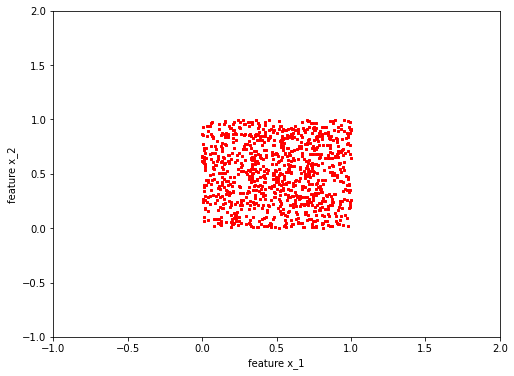

In [24]:
##plot scatter plot

plt.figure(figsize=(8,6))
plt.scatter(df.iloc[:, 0].values, df.iloc[:, 1].values,s = 3, c = 'red', marker = 's')
plt.xlim([-1,2])
plt.ylim([-1,2])
plt.xlabel('feature x_1')
plt.ylabel('feature x_2')
plt.show()

<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


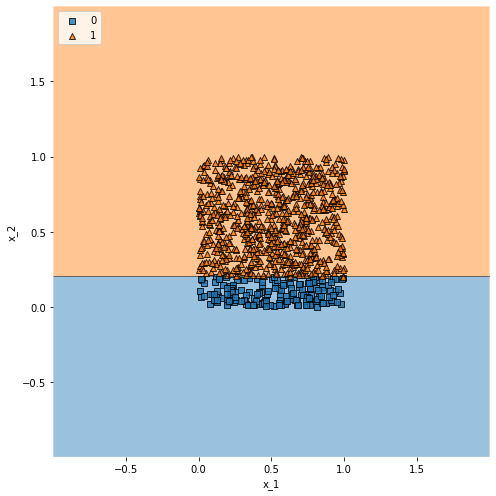

In [25]:
fig, ax = plt.subplots(figsize=(7, 7)) 
X=df.iloc[:,:-1]
X=X.to_numpy()
plot_decision_regions(X, df['y'].to_numpy(), clf=cf) 
plt.xlabel('x_1') 
plt.ylabel('x_2') 
plt.legend(loc='upper left') 
plt.tight_layout() 
plt.show()


In [26]:
df=pd.read_csv('D2.txt', header=None, sep=' ', names= ["x1", "x2", "y"])
cf=classifier()
cf.fit(df)
node_counts=cf.print_tree()
print("Total node_counts: ",node_counts)

<IPython.core.display.Javascript object>

Node: x1 >= 0.533076 ( Infogain_ratio:  0.22380611436687328 )
     left child:Node: x2 >= 0.228007 ( Infogain_ratio:  0.40277675382774364 )
          left child:Node: x2 >= 0.424906 ( Infogain_ratio:  0.1751133281825154 )
               left child:1
               right child:Node: x1 >= 0.708127 ( Infogain_ratio:  0.5206601917193016 )
                    left child:1
                    right child:Node: x2 >= 0.32625 ( Infogain_ratio:  0.34644489742573276 )
                         left child:Node: x1 >= 0.595471 ( Infogain_ratio:  0.5023576805798504 )
                              left child:Node: x1 >= 0.646007 ( Infogain_ratio:  0.3191750665186215 )
                                   left child:1
                                   right child:Node: x2 >= 0.403494 ( Infogain_ratio:  1.0 )
                                        left child:1
                                        right child:0
                              right child:0
                         right child:0
      

<IPython.core.display.Javascript object>

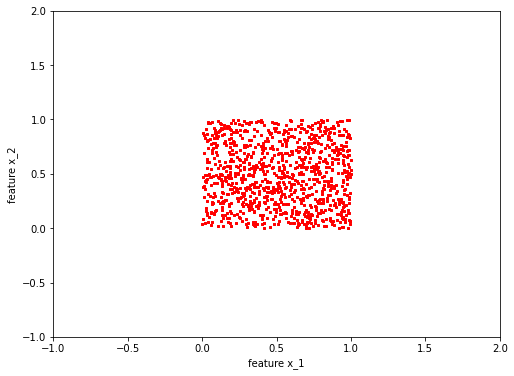

In [27]:
##plot scatter plot

plt.figure(figsize=(8,6))
plt.scatter(df.iloc[:, 0].values, df.iloc[:, 1].values,s = 3, c = 'red', marker = 's')
plt.xlim([-1,2])
plt.ylim([-1,2])
plt.xlabel('feature x_1')
plt.ylabel('feature x_2')
plt.show()

<IPython.core.display.Javascript object>

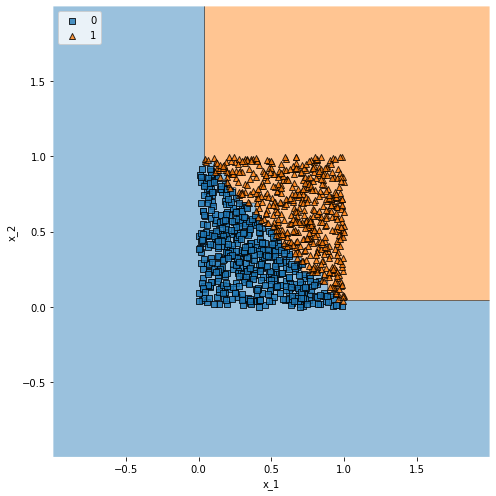

In [28]:
fig, ax = plt.subplots(figsize=(7, 7)) 
X=df.iloc[:,:-1]
X=X.to_numpy()
plot_decision_regions(X, df['y'].to_numpy(), clf=cf) 
plt.xlabel('x_1') 
plt.ylabel('x_2') 
plt.legend(loc='upper left') 
plt.tight_layout() 
plt.show()


###2.7

In [29]:
df=pd.read_csv('Dbig.txt', header=None, sep=' ', names= ["x1", "x2", "y"])
##dataset split if required
total_data=df.loc[np.random.permutation(df.index)]
train = total_data[:8192]
test = total_data[8192:]
D32 = train[:32]
D128 = train[:128]
D512 = train[:512]
D2048 = train[:2048]
D8192 = train

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

D 32


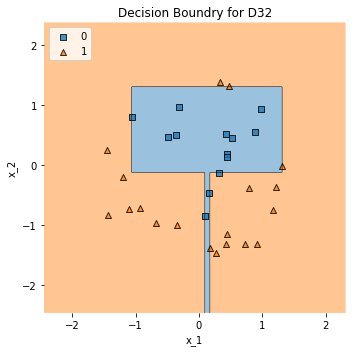

Node: x2 >= -0.131317 ( Infogain_ratio:  0.30556596201475233 )
     left child:Node: x2 >= 1.310034 ( Infogain_ratio:  0.5292812149097395 )
          left child:1
          right child:Node: x1 >= 1.312117 ( Infogain_ratio:  0.6067765245284924 )
               left child:1
               right child:Node: x1 >= -1.06116 ( Infogain_ratio:  1.0 )
                    left child:0
                    right child:1
     right child:Node: x1 >= 0.174128 ( Infogain_ratio:  0.14113390900849015 )
          left child:1
          right child:Node: x1 >= 0.09618 ( Infogain_ratio:  1.0 )
               left child:0
               right child:1
Accuracy:  0.8174778761061947 Mean Squared error:  0.18252212389380532
D 128


/usr/local/lib/python3.8/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


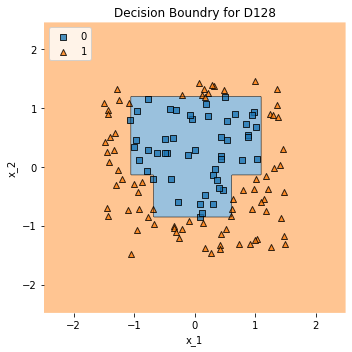

Node: x2 >= -0.854968 ( Infogain_ratio:  0.21467023630561902 )
     left child:Node: x1 >= -1.06116 ( Infogain_ratio:  0.2743008122858039 )
          left child:Node: x1 >= 1.102817 ( Infogain_ratio:  0.35769031335134416 )
               left child:1
               right child:Node: x2 >= 1.196545 ( Infogain_ratio:  0.4572488967685506 )
                    left child:1
                    right child:Node: x2 >= -0.131317 ( Infogain_ratio:  0.3694154280286047 )
                         left child:0
                         right child:Node: x1 >= 0.60696 ( Infogain_ratio:  0.3806701399209727 )
                              left child:1
                              right child:Node: x1 >= -0.684671 ( Infogain_ratio:  1.0 )
                                   left child:0
                                   right child:1
          right child:1
     right child:1
Accuracy:  0.9341814159292036 Mean Squared error:  0.06581858407079647
D 512


/usr/local/lib/python3.8/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


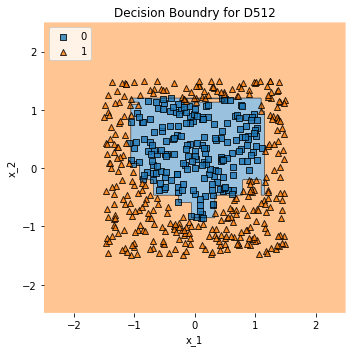

Node: x2 >= -0.856344 ( Infogain_ratio:  0.22970164285397418 )
     left child:Node: x2 >= 1.202039 ( Infogain_ratio:  0.2632038700969595 )
          left child:1
          right child:Node: x1 >= -1.090884 ( Infogain_ratio:  0.3109348120915749 )
               left child:Node: x1 >= 1.150719 ( Infogain_ratio:  0.4088932534876292 )
                    left child:1
                    right child:Node: x2 >= -0.470278 ( Infogain_ratio:  0.2743399052448986 )
                         left child:Node: x1 >= -1.056916 ( Infogain_ratio:  0.16479226199375446 )
                              left child:Node: x2 >= 1.196545 ( Infogain_ratio:  0.15434172325544568 )
                                   left child:Node: x2 >= 1.199526 ( Infogain_ratio:  1.0 )
                                        left child:0
                                        right child:1
                                   right child:Node: x1 >= 1.092916 ( Infogain_ratio:  0.1629790353276961 )
                              

/usr/local/lib/python3.8/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


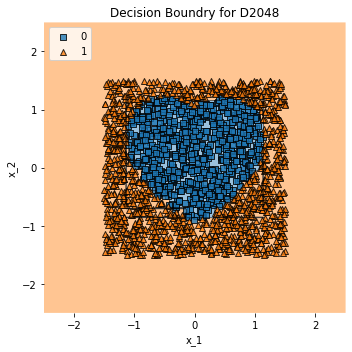

Node: x2 >= -0.856344 ( Infogain_ratio:  0.23375967805117476 )
     left child:Node: x2 >= 1.226089 ( Infogain_ratio:  0.25480433344231723 )
          left child:1
          right child:Node: x1 >= -1.138432 ( Infogain_ratio:  0.3159018572142174 )
               left child:Node: x1 >= 1.135402 ( Infogain_ratio:  0.4161451375859253 )
                    left child:1
                    right child:Node: x2 >= -0.67889 ( Infogain_ratio:  0.23523149731704862 )
                         left child:Node: x1 >= 1.078525 ( Infogain_ratio:  0.21262821616294877 )
                              left child:Node: x1 >= 1.132337 ( Infogain_ratio:  0.4588931484094657 )
                                   left child:0
                                   right child:Node: x2 >= 0.34806 ( Infogain_ratio:  0.2063885288762335 )
                                        left child:Node: x2 >= 0.835291 ( Infogain_ratio:  1.0 )
                                             left child:1
                            

/usr/local/lib/python3.8/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


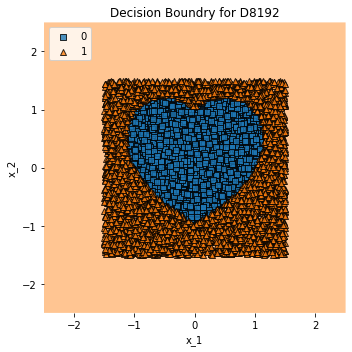

Node: x2 >= -0.926187 ( Infogain_ratio:  0.23096610948150004 )
     left child:Node: x1 >= 1.135791 ( Infogain_ratio:  0.24946813450956626 )
          left child:1
          right child:Node: x1 >= -1.138432 ( Infogain_ratio:  0.32324431103780493 )
               left child:Node: x2 >= 1.232245 ( Infogain_ratio:  0.3893067403203644 )
                    left child:1
                    right child:Node: x2 >= -0.683379 ( Infogain_ratio:  0.25668035076332246 )
                         left child:Node: x1 >= 1.07081 ( Infogain_ratio:  0.19331162254206524 )
                              left child:Node: x1 >= 1.135738 ( Infogain_ratio:  0.27135562853856715 )
                                   left child:0
                                   right child:Node: x2 >= 0.280301 ( Infogain_ratio:  0.24944272822742652 )
                                        left child:Node: x2 >= 0.786355 ( Infogain_ratio:  0.8818904667997012 )
                                             left child:1
         

In [30]:
err=[]
nodes=[]
for data in [D32, D128, D512, D2048, D8192]:
  _, error, node_count = print_acc_err(data, test)
  err.append(error)
  nodes.append(node_count)
print(nodes)
print(err)

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Nodes vs err graph for all datasets')

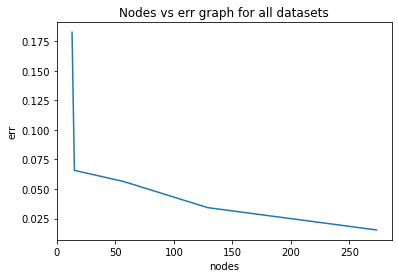

In [31]:
#plot n vs err
plt.plot(nodes, err)
plt.xlabel("nodes")
plt.ylabel("err")
plt.title("Nodes vs err graph for all datasets")

In [32]:
for i,data in enumerate([D32, D128, D512, D2048, D8192]):
  print("Number of nodes for D"+str(data.shape[0])+": ",nodes[i])
  print("Error for D"+str(data.shape[0])+": ",err[i])

<IPython.core.display.Javascript object>

Number of nodes for D32:  13
Error for D32:  0.18252212389380532
Number of nodes for D128:  15
Error for D128:  0.06581858407079647
Number of nodes for D512:  57
Error for D512:  0.05641592920353982
Number of nodes for D2048:  129
Error for D2048:  0.034292035398230086
Number of nodes for D8192:  273
Error for D8192:  0.015486725663716814


###2.2

In [66]:
data=[[0, 0, 0],[0,1,1],[1,0,1],[1,1,0]]  
# Create the pandas DataFrame
df = pd.DataFrame(data, columns=['x1', 'x2', 'y'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

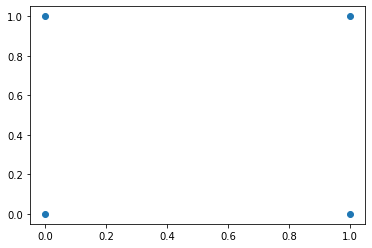

In [67]:
plt.scatter(df['x1'],df['x2'])

In [68]:
cf=classifier()
cf.fit(df)
node_counts=cf.print_tree()
print("Total node_counts: ",node_counts)

<IPython.core.display.Javascript object>

feature Node:  x1 Split value:  0 Entropy: 1.0 Infogain:  0.0 Infogain_ratio:  nan
feature Node:  x1 Split value:  1 Entropy: 1.0 Infogain:  0.0 Infogain_ratio:  0.0
feature Node:  x2 Split value:  0 Entropy: 1.0 Infogain:  0.0 Infogain_ratio:  nan
feature Node:  x2 Split value:  1 Entropy: 1.0 Infogain:  0.0 Infogain_ratio:  0.0
Best feature Node:  x2 Best Split value:  1 Entropy: 1.0 Infogain:  0.0 Infogain_ratio:  0.0
0
Total node_counts:  1


<ipython-input-51-5386b9a858ef>:24: RuntimeWarning: invalid value encountered in double_scalars
  IGratio=((H_y-ent)/ent_S)
<ipython-input-51-5386b9a858ef>:25: RuntimeWarning: invalid value encountered in double_scalars
  if(infogain_ratio<=((H_y-ent)/ent_S)):


<IPython.core.display.Javascript object>

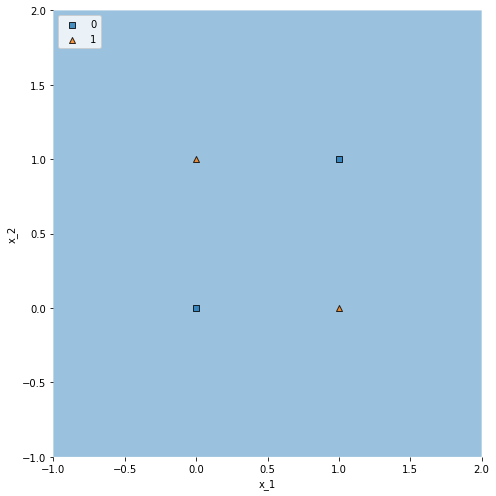

In [69]:
fig, ax = plt.subplots(figsize=(7, 7)) 
X=df.iloc[:,:-1]
X=X.to_numpy()
plot_decision_regions(X, df['y'].to_numpy(), clf=cf) 
plt.xlabel('x_1') 
plt.ylabel('x_2') 
plt.legend(loc='upper left') 
plt.tight_layout() 
plt.show()

##Question # 3

<IPython.core.display.Javascript object>

Scikit Learn based DT classifier results
Number of nodes for D32:  13
Error for D32:  0.13219026548672566
Number of nodes for D128:  23
Error for D128:  0.06969026548672566
Number of nodes for D512:  47
Error for D512:  0.03982300884955752
Number of nodes for D2048:  101
Error for D2048:  0.024889380530973452
Number of nodes for D8192:  245
Error for D8192:  0.01327433628318584


Text(0.5, 1.0, 'Nodes vs err graph for all datasets - ScikitLearn')

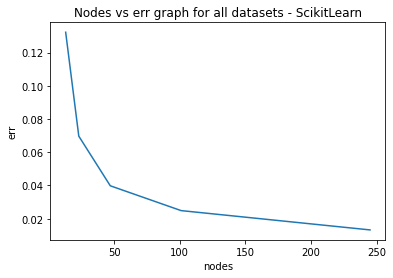

In [33]:
##through scikit learn
from sklearn.tree import DecisionTreeClassifier
DTclf = DecisionTreeClassifier(random_state=0)
scikitlean_err=[]
scikitlean_nodes=[]
for i,data in enumerate([D32, D128, D512, D2048, D8192]):
  Xtrain=data.iloc[:,:-1]
  DTclf.fit(Xtrain,data['y'])
  Xtest=test.iloc[:,:-1]
  Ypred=DTclf.predict(Xtest)
  scikitlean_err.append(mean_squared_error(Ypred, test['y']))
  scikitlean_nodes.append(DTclf.tree_.node_count)
#print(scikitlean_nodes,scikitlean_err)
print("Scikit Learn based DT classifier results")
for i,data in enumerate([D32, D128, D512, D2048, D8192]):
  print("Number of nodes for D"+str(data.shape[0])+": ",scikitlean_nodes[i])
  print("Error for D"+str(data.shape[0])+": ",scikitlean_err[i])
plt.plot(scikitlean_nodes, scikitlean_err)
plt.xlabel("nodes")
plt.ylabel("err")
plt.title("Nodes vs err graph for all datasets - ScikitLearn")

##Question # 4

In [490]:
x=np.linspace(0, 2*math.pi, 100)
# Train a model with input noise
n = 15
# number of sampled elements
std = 0.2
# standard deviation
x_train_no_noise = np.sort(np.random.choice(x, n, replace=False))
y_train_no_noise=np.sin(x_train_no_noise)
x_train = np.sort(np.add(x_train_no_noise, np.random.normal(0, std, size=n)))
y_train = np.sin(x_train)
poly = lagrange(x_train, y_train)
# Test the trained model without input noise
x_test = np.sort(np.random.choice(x, n, replace=False)) 
# random select from x
y_test = np.sin(x_test)
y_inter = Polynomial(poly.coef[::-1])(x_test)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

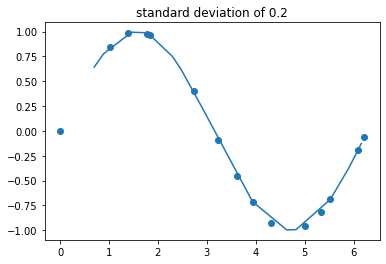

Train Error:  0.0325052555012573
Test Error:  1.2685270306386672e-08


In [491]:
plt.scatter(x_train_no_noise,np.sin(x_train_no_noise))
plt.plot(x_test,y_inter)
plt.title('standard deviation of 0.2')
plt.show()
print("Train Error: ",mean_squared_error(y_train,y_train_no_noise))
print("Test Error: ",mean_squared_error(y_test,y_inter))